# Animating Ocean Color Satellite Data (ESA)

#### Requirements:
- Python (Anaconda recommended)
- IDE / Text editor that can handle Jupyter Notebooks
- Packages:
    - xarray
    - matplotlib
    - cartopy
    - numpy
    - tqdm (optional)

- System:
    - Tested on Windows but should work on Linux, too

#### Other:
More download options can be found on https://climate.esa.int/en/projects/ocean-colour/data/ and https://www.oceancolour.org/ <br />The animation takes quite a while so please be patient. The progressbar shows the estimated time left after the symbol "<".

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from matplotlib.colors import LogNorm
import datetime as dt
from tqdm.notebook import tqdm

In [8]:
#choose precision; with example data, 24 ~ 1.0° lon, 2.0° lat, 10 ~ 0.42° lon, 0.83° lat
#here we use 0.5 degree for lat and lon but this means that the animation will take a long while
lon = 12
lat = 6

In [9]:
#link to dataset (OPeNDAP Dataset Access Form)
file = f"https://www.oceancolour.org/thredds/dodsC/CCI_ALL-v5.0-MONTHLY?lat[0:{lat}:4319],lon[0:{lon}:8639],time[0:1:291],chlor_a[0:1:291][0:{lat}:4319][0:{lon}:8639]"

In [10]:
#opening the dataset with Xarray
ds = xr.open_dataset(file)

  0%|          | 0/292 [00:00<?, ?it/s]

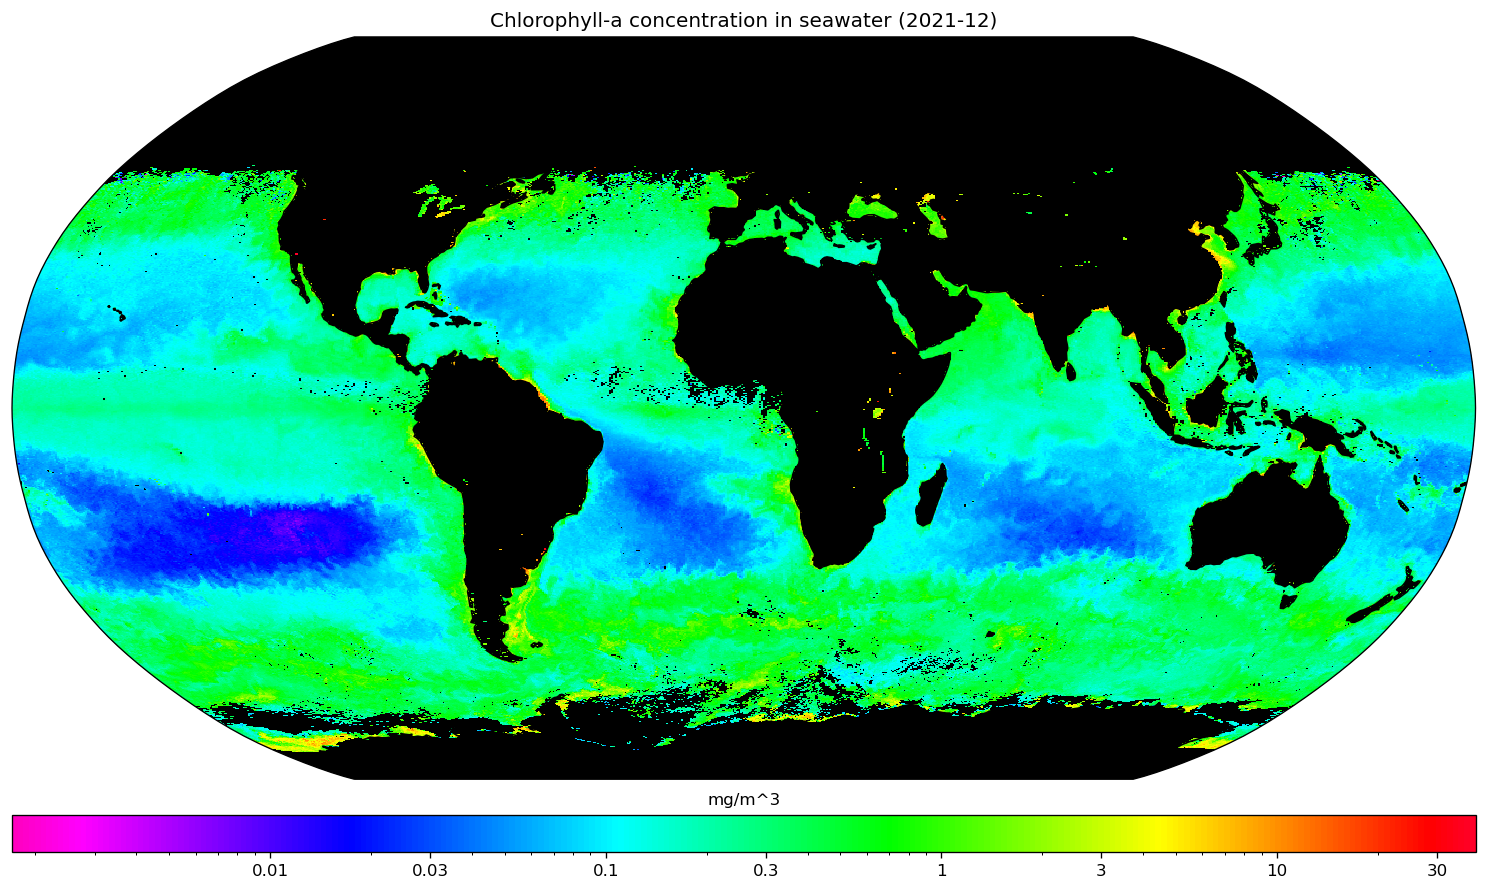

In [11]:
with tqdm(total=len(ds.time.values), colour="green") as pbar:
    #set figure, facecolor helps to keep text nice
    fig = plt.figure(facecolor="white", figsize=(16, 9), dpi=1920/16)
    #set axes, preferred projection
    ax = plt.axes(projection=ccrs.Robinson())
    #global axes, coastlines to map
    ax.set_global()
    ax.coastlines()
    #background color
    ax.patch.set_facecolor(color='black')
    #color levels, can be linear or log like in this case (check norm!)
    clevs  = np.logspace(-2, 1.778, 20, base=10)
    #title with each month
    title = ax.set_title(f"Chlorophyll-a concentration in seawater ({ds.time[0].dt.year.values}-{ds.time[0].dt.month.values})")
    #first frame
    cs = ax.pcolormesh(ds.lon, ds.lat, ds.chlor_a.isel(time=0), transform=ccrs.PlateCarree(), cmap="gist_rainbow_r", shading='auto', norm=LogNorm(), animated=True)
    #locatable axis -> easier to fit colorbar
    divider = make_axes_locatable(ax)
    #define axis for the colorbar
    ax_cb = divider.new_vertical(size="5%", pad=0.3, axes_class=plt.Axes, pack_start=True)
    #add axis
    fig.add_axes(ax_cb)
    #add colorbar
    cb = fig.colorbar(cs, cax=ax_cb, orientation="horizontal", ticks = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 60])
    #tile for colorbar
    cb.ax.set_title('mg/m^3',fontsize=10)
    #ticklabels for colorbar (default often ugly)
    cb.set_ticklabels(["0.01", "0.03", "0.1", "0.3", "1", "3", "10", "30", "60"])

    #animation loop
    def animate(i):
        #new values for colormesh
        cs.set_array(ds.chlor_a.isel(time=i).values.ravel())
        #change title
        title.set_text(f"Chlorophyll-a concentration in seawater ({ds.time[i].dt.year.values}-{ds.time[i].dt.month.values})")
        pbar.update(1)
        return cs,title,

    #create animation. Each month has own frame, interval between frames 200 ms
    anim = animation.FuncAnimation(fig, animate, frames=len(ds.time.values), repeat=False, init_func=None, interval=200, blit=True)
    anim.save('OC.mp4', writer=animation.FFMpegWriter())